<a href="https://colab.research.google.com/github/hagusta/colab/blob/master/fastai_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash

bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'


Mounted at /content/gdrive


In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
import fastai
import torch
from pathlib import Path
import numpy as np
from fastai.vision import *
#from fastai.conv_learner import *
#from fastai.dataset import *

#import json, pdb
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET

#torch.cuda.set_device(0)

In [ ]:
torch.backends.cudnn.benchmark=True

In [ ]:
!ls "$root_dir"/data/ImageChips_0/images/|grep jpg$|wc -l
!ls "$root_dir"/data/ImageChips_1/images/|grep jpg$|wc -l
!ls "$root_dir"/data/ImageChips_2/images/|grep jpg$|wc -l

2259
1008
3006


In [ ]:
PATH=Path(root_dir)
fclas=root_dir+"data/ImageChips_2/labels/000002987.xml"
fimg=root_dir+"data/ImageChips_2/images/000002987.jpg"

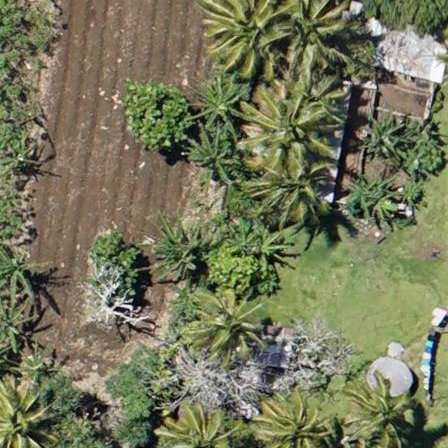

In [ ]:
img=open_image(fimg)
img

In [ ]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    im.show(ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_circle(ax, c):
  #c=[ycenter,xcenter,radius]
  patch = ax.add_patch(patches.Circle(c[:2], *c[-1:], fill=False, edgecolor='white', lw=2))
  draw_outline(patch, 4)

In [ ]:
classes={0:'background',1:'palm'}

def xmlBBoxParse(fname,classes) :
  tree=ET.parse(fname)
  root=tree.getroot()
  bbox=[]
  cls=[]
  labels=[]
  fname=root.getiterator('filename')[0].text
  for obj in root.iter('object'):
    #print(obj.find('bndbox').find('xmin').text)
    xmin=np.float(obj.find('bndbox').find('xmin').text)
    ymin=np.float(obj.find('bndbox').find('ymin').text)
    xmax=np.float(obj.find('bndbox').find('xmax').text)
    ymax=np.float(obj.find('bndbox').find('ymax').text)
    bbox.append([ymin,xmin,ymax,xmax])
    c=int(obj.find('name').text)
    cls.append(c)
    labels.append(classes[c])
  return fname,bbox,cls,labels

def xmlCBoxPars(fname,classes,avg_rad=35.0):
  tree=ET.parse(fname)
  root=tree.getroot()
  bbox=[]
  cls=[]
  labels=[]
  offcenter=[]
  
  fname=root.getiterator('filename')[0].text
  w=float(root.find('size').find('width').text)
  h=float(root.find('size').find('height').text)
  for obj in root.iter('object'):

    xmin=np.float(obj.find('bndbox').find('xmin').text)
    ymin=np.float(obj.find('bndbox').find('ymin').text)
    xmax=np.float(obj.find('bndbox').find('xmax').text)
    ymax=np.float(obj.find('bndbox').find('ymax').text)
    x=np.abs(xmin-xmax)/2
    y=np.abs(ymin-ymax)/2
    radius=max(x,y,avg_rad)
    if xmax-radius <= 0 or xmin == 0:
      xcenter = xmax - radius
    else :
      xcenter= xmin + radius
    if ymax - radius <= 0 or ymin==0:
      ycenter = ymax - radius
    else:
      ycenter=ymin + radius
    
    bbox.append([ycenter,xcenter,radius])
    c=int(obj.find('name').text)
    cls.append(c)
    labels.append(classes[c])
    if xcenter < 0 or ycenter < 0 or xcenter > w or ycenter > h:
      offcenter.append(True)
    else:
      offcenter.append(False)
  return fname,bbox,cls,labels,offcenter

In [ ]:
_,bbox,cls,labels=xmlBBoxParse(fclas,classes=classes)
_,cbox,_,_,offcenter=xmlCBoxPars(fclas,classes=classes)

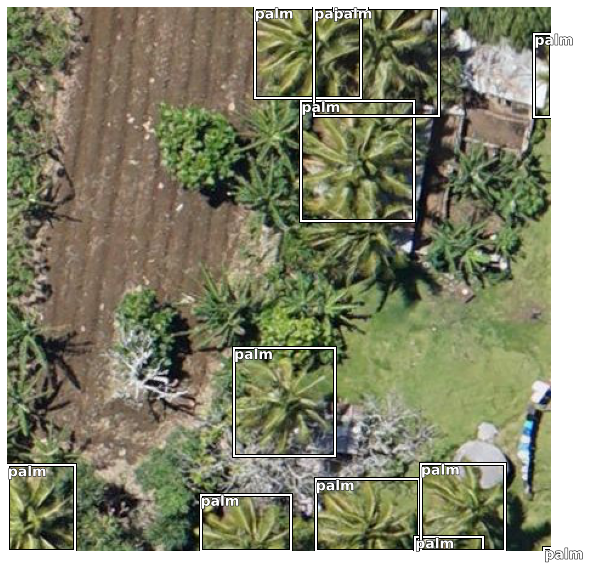

In [ ]:
boundbox = ImageBBox.create(*img.size, bboxes=bbox, labels=cls, classes=classes)
#bbox = ImageBBox.create(*img.size, bboxes=[[ 0.0, 203.5, 74.92, 291.31]], labels=[1], classes=classes)
img.show(y=boundbox,figsize=(10,10))

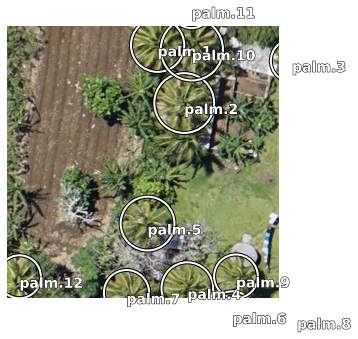

In [ ]:
def drawBBoxex(img,bbox,labels,classes,figsize=(10,10)):
  ax=show_img(img,figsize=figsize)
  i=1
  for c,_b in zip(labels,bbox):
    b=[_b[1],_b[0],_b[3]-_b[1],_b[2]-_b[0]]
    draw_rect(ax,b)
    draw_text(ax,(_b[1],_b[0]),classes[c]+'.'+str(i))
    i=i+1

def drawCBoxex(img,bbox,labels,classes,figsize=(10,10)):
  ax=show_img(img,figsize=figsize)
  i=1
  for c, b in zip(labels,bbox):
    _b=[b[1],b[0],b[2]]
    draw_circle(ax,_b)
    draw_text(ax,(b[1],b[0]),classes[c]+'.'+str(i))
    i=i+1
#drawBBoxex(img,bbox,cls,classes)
drawCBoxex(img,cbox,cls,classes,figsize=(5,5))

The figure shows some center is off frame. Palm center is one of most important feature the model have to detect. Therefore remove labels with out of frame center.

In [ ]:
cbox,bbox


([[31.015, 247.405, 43.905],
  [126.275, 291.295, 49.285000000000004],
  [56.67, 469.06, 35.0],
  [431.38, 296.42, 42.58999999999999],
  [324.945, 230.83499999999998, 44.32499999999999],
  [471.57, 370.83, 35.0],
  [438.85, 196.16, 37.31],
  [480.26, 477.28, 35.0],
  [411.945, 376.565, 36.05500000000001],
  [37.83, 303.85, 51.269999999999996],
  [-32.17, 303.48, 35.0],
  [412.62, 19.630000000000003, 35.379999999999995]],
 [[0.0, 203.5, 74.92, 291.31],
  [76.99, 242.01, 175.56, 334.5],
  [21.67, 434.06, 90.07, 448.0],
  [388.79, 253.83, 448.0, 339.01],
  [280.62, 186.51, 369.27, 269.69],
  [436.57, 335.83, 448.0, 391.98],
  [401.54, 158.85, 448.0, 233.47],
  [445.26, 442.28, 448.0, 448.0],
  [375.89, 340.51, 448.0, 409.78],
  [0.0, 252.58, 89.1, 355.12],
  [0.0, 268.48, 2.83, 296.11],
  [377.24, 0.0, 448.0, 55.01]])

In [ ]:
offcenter,cls

([False,
  False,
  True,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  True,
  False],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
PATH_IMG=PATH/"data/ImageChips_2/images"
PATH_LBL=PATH/"data/ImageChips_2/labels"

In [ ]:
list(PATH_IMG.iterdir())[:5]

[PosixPath('/content/gdrive/My Drive/data/ImageChips_2/images/000001157.jgw'),
 PosixPath('/content/gdrive/My Drive/data/ImageChips_2/images/000001167.jpg.ovr'),
 PosixPath('/content/gdrive/My Drive/data/ImageChips_2/images/000001160.jpg.ovr'),
 PosixPath('/content/gdrive/My Drive/data/ImageChips_2/images/000001171.jgw'),
 PosixPath('/content/gdrive/My Drive/data/ImageChips_2/images/000001153.jgw')]

In [ ]:
!ls '/content/gdrive/My Drive/data/ImageChips_2/images/'|grep -v jpg$|head

000000000.jgw
000000000.jpg.aux.xml
000000000.jpg.ovr
000000001.jgw
000000001.jpg.aux.xml
000000001.jpg.ovr
000000002.jgw
000000002.jpg.aux.xml
000000002.jpg.ovr
000000003.jgw
